# 7.5. Pooling



Pooling = Agrupamento

Em muitos casos, nossa tarefa final faz alguma pergunta global sobre a imagem, por exemplo, ela contém um gato? Consequentemente, as unidades de nossa camada final devem ser sensíveis a toda a entrada.

Quanto mais fundo formos na rede, maior será o campo receptivo (relativo à entrada) ao qual cada nó oculto é sensível. Reduzir a resolução espacial acelera esse processo, pois os kernels de convolução cobrem uma área efetiva maior.

Esta seção apresenta camadas de agrupamento , que atendem aos propósitos duplos de mitigar a sensibilidade das camadas convolucionais à localização e de reduzir a amostragem espacial das representações.

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# 7.5.1. Maximum Pooling and Average Pooling

Assim como as camadas convolucionais, os operadores de pooling consistem em uma janela de formato fixo que é deslizada sobre todas as regiões na entrada de acordo com seu passo, computando uma única saída para cada local atravessado pela janela de formato fixo (às vezes conhecida como janela de pooling ). No entanto, diferentemente do cálculo de correlação cruzada das entradas e kernels na camada convolucional, __a camada de pooling não contém parâmetros (não há kernel)__. Em vez disso, os operadores de pooling são determinísticos, __normalmente calculando o valor máximo ou médio dos elementos na janela de pooling__. Essas operações são chamadas de pooling máximo (max-pooling para abreviar) e pooling médio, respectivamente.

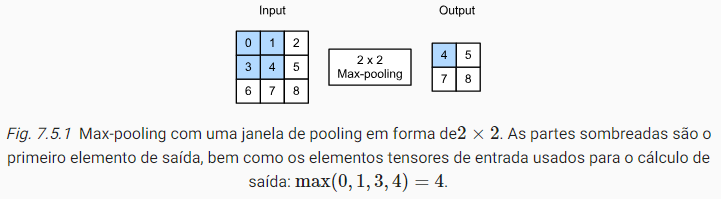

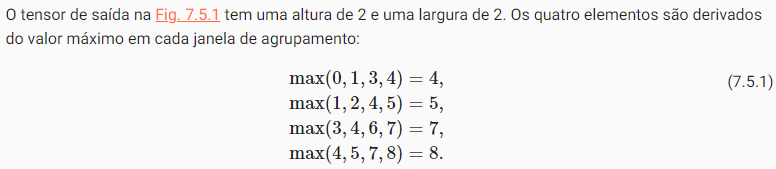

__***Quanto maior o kernel do pool, menor será a imagem resultante. Um kernel de pooling dois por dois resulta em uma imagem cujas dimensões são metade do original. Um kernel de agrupamento de três por três torna a imagem resultante um terço
o tamanho do original e assim por diante.***__

O agrupamento médio é essencialmente tão antigo quanto as CNNs. A ideia é semelhante a reduzir a amostragem de uma imagem. Em vez de apenas pegar o valor de cada segundo (ou terceiro) pixel para a imagem de resolução mais baixa, podemos fazer a média sobre pixels adjacentes para obter uma imagem com melhor relação sinal-ruído, já que estamos combinando as informações de vários pixels adjacentes.

Em quase todos os casos, o agrupamento máximo, como também é chamado, é preferível ao agrupamento médio.

Em ambos os casos, assim como com o operador de correlação cruzada, podemos pensar na janela de agrupamento como começando do canto superior esquerdo do tensor de entrada e deslizando sobre ele da esquerda para a direita e de cima para baixo. Em cada local que a janela de agrupamento atinge, ela calcula o valor máximo ou médio do subtensor de entrada na janela, dependendo se o agrupamento máximo ou médio é empregado.




No código abaixo, implementamos a propagação para frente da camada de pooling na função __pool2d__. Esta função é similar à __corr2d__ na Seção 7.2. No entanto, __nenhum kernel é necessário__, computando a saída como o máximo ou a média de cada região na entrada.

In [2]:
def pool2d(X, pool_size, mode='max'):                                       # mode defaut set with max.
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()                   # pega o valor máximo dentro da região selecionada
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()                  # pega o valor médio dentro da região selecionada
    return Y

Podemos construir o tensor de entrada X na Fig. 7.5.1 para validar a saída da camada de agrupamento máximo bidimensional.

In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

Também podemos experimentar a camada de agrupamento média.

In [4]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

# 7.5.2. Padding and Stride

Assim como nas camadas convolucionais, as camadas de pooling alteram o formato de saída. E, como antes, podemos ajustar a operação para atingir um formato de saída desejado preenchendo a entrada e ajustando o passo. 

Podemos demonstrar o uso de preenchimento e passos em camadas de pooling por meio da camada max-pooling bidimensional integrada da estrutura de aprendizado profundo. Primeiro, construímos um tensor de entrada Xcujo formato tem quatro dimensões, onde o número de exemplos (tamanho do lote) e o número de canais são ambos 1.



In [14]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

# _Como o pooling agrega informações de uma área, as estruturas de aprendizado profundo têm como padrão combinar tamanhos de janelas de pooling e passo_. 

Por exemplo, se usarmos uma janela de pooling com shape (3, 3), obtemos um formato de passo de (3, 3) por padrão.

In [9]:
pool2d = nn.MaxPool2d(3)                                             # utilizando a biblioteca nn
# Pooling has no model parameters, hence it needs no initialization
pool2d(X)  # Como o passo é 3, apenas 1 pooling é aplicado, cujo máximo na janela 3x3 é 10.

tensor([[[[10.]]]])

Nem é preciso dizer que o passo e o preenchimento podem ser especificados manualmente para substituir os padrões do framework, se necessário.

In [10]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)        # janela de pooling com shape (3, 3)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

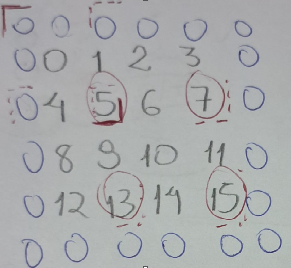

# 7.5.3. Canais múltiplos

Ao processar dados de entrada multicanal, a camada de pooling agrupa cada canal de entrada separadamente, em vez de somar as entradas em canais como em uma camada convolucional (relembre Fig. 7.4.1).

Isso significa que o número de canais de saída para a camada de pooling é o mesmo que o número de canais de entrada. 

Abaixo, concatenaremos tensores X e X + 1 na dimensão do canal para construir uma entrada com dois canais.

In [15]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [16]:
X.shape

torch.Size([1, 2, 4, 4])

Como podemos ver, o número de canais de saída ainda é dois após o agrupamento.

In [17]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

# 7.5.4. Resumo

- O pooling é uma operação extremamente simples: agrupa os máximos ou as médias. 
- Ele faz exatamente o que seu nome indica, agrega resultados em uma janela de valores.
- Toda a semântica de convolução, como strides e padding, se aplicam da mesma forma que antes.
- Observe que o pooling é indiferente aos canais, ou seja, ele deixa o número de canais inalterado e se aplica a cada canal separadamente.
- Por fim, das duas escolhas populares de pooling, __o max-pooling é preferível ao average pooling__, pois confere algum grau de __invariância__ à saída.
- Uma escolha popular é escolher um tamanho de janela de pooling de 2x2 para dividir a resolução espacial da saída.

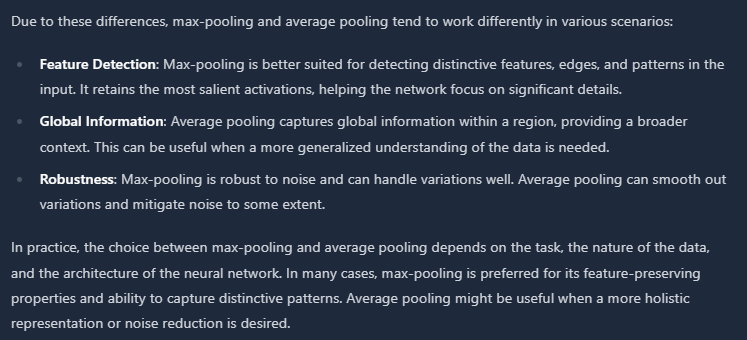

# Custo computacional para o Foward propagation com Pooling

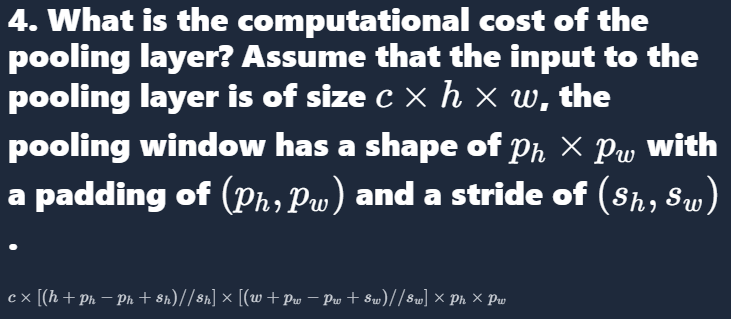

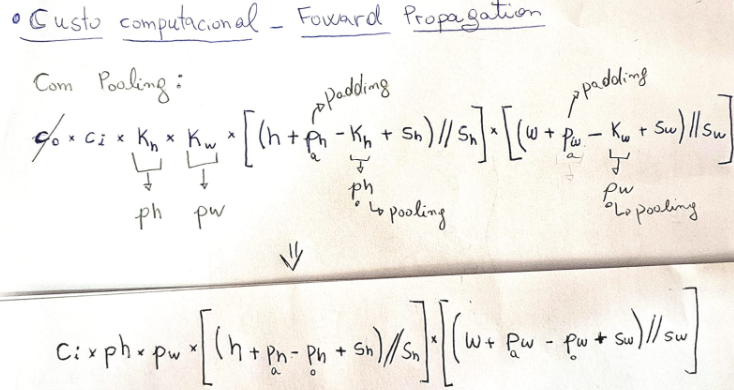



# 7.5.5. Exercícios

# Ex. 1 - Implemente o agrupamento médio por meio de uma convolução.

In [20]:
import torch
from d2l import torch as d2l

# ------------------------------------------------------------------------------------------
# FUNÇÃO PARA CONVOLUÇÃO COM APENAS 1 ENTRADA E 1 SAÍDA:
# Também está dentro da biblioteca d2l: d2l.corr2d
def corr2d(X, K):                                                   # Realiza a CONVOLUÇÃO
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()             # CONVOLUÇÃO


    return Y
# ------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------
# DADOS:
X = torch.tensor([
    [0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]
])

K = torch.tensor([
    [0.0, 1.0], [2.0, 3.0]
])
# ------------------------------------------------------------------------------------------
convolu = corr2d(X, K)
# ------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------

def pool2d_avg(X, convolu=convolu):                                       # mode defaut set with max.
    p_h, p_w = convolu.shape
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = X[i: i + p_h, j: j + p_w].mean()                  # pega o valor médio dentro da região selecionada

    # for i in range(Y.shape[0]):
    #     for j in range(Y.shape[1]):
    #         Y[i, j] = ((X[i:i + h, j:j + w]).sum()) / (p_h * p_w)
    return Y

media = pool2d_avg(X, convolu=convolu)
print(X)
print(media)

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])
tensor([[2., 3.],
        [5., 6.]])


# Ex. 6 - Precisamos de uma camada de pooling mínima separada? Você pode substituí-la por outra operação?

In [21]:
# POOL COM OPÇÃO PARA MAX, MIN E AVG.
import torch
from torch import nn
from d2l import torch as d2l

def pool2d(X, pool_size, mode='max'):                                       # mode defaut set with max.
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].min()                   # pega o valor máximo dentro da região selecionada
            elif mode == 'min':
                Y[i, j] = X[i: i + p_h, j: j + p_w].min()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()                  # pega o valor médio dentro da região selecionada
    return Y



X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
p = pool2d(X, (2, 2), 'min')
print(X)
print(p)

X1 = torch.tensor([[2.0, 7.0, 1.0], [9.0, 3.0, 2.0], [4.0, 7.0, 1.0]])
p1 = pool2d(X1, (2, 2), 'min')
print(X1)
print(p1)

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])
tensor([[0., 1.],
        [3., 4.]])
tensor([[2., 7., 1.],
        [9., 3., 2.],
        [4., 7., 1.]])
tensor([[2., 1.],
        [3., 1.]])


# Ex. 7 - Poderíamos usar a operação softmax para pooling. Por que ela pode não ser tão popular?

Qualquer operação pode ser utilizada para pooling: min, max, avg, softmax, sin, cos, tb; entretanto, nem todas terão real utilidade.

O softmax não é utilizado por:

Estabilidade Numérica: Softmax é sensível à escala dos valores de entrada. Quando aplicado a um grande conjunto de valores, envolve exponenciação, o que pode levar a instabilidade numérica e problemas de overflow. Isso pode fazer com que os gradientes durante a retropropagação se tornem muito pequenos ou grandes, afetando o processo de aprendizagem.

Consistência arquitetônica: Softmax é comumente usado na camada de saída de uma rede neural para tarefas de classificação.

# Outras respostas:

https://pandalab.me/archives/pooling